# Convolutional Neural Networks

## Imports and constants

In [1]:

import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchmetrics import Accuracy
from torchinfo import summary
from tqdm.notebook import tqdm

import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from datetime import datetime
import os
import shutil
import subprocess
import webbrowser
import time
import csv
import numpy as np
import pandas as pd


TENSORBOARD = True
TENSORBOARD_TAB = TENSORBOARD
EPOCHS = 15
BATCH_SIZE = 32
LEARNING_RATE = 0.001
models_path = 'models'
plots_path = 'graphs'
runs_path = 'runs'

## Load data & initial preprocessing

In [2]:
# Download the FashionMNIST train and test datasets
train_set_full = datasets.FashionMNIST(root='./datasets/', train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.FashionMNIST(root='./datasets', train=False, download=True, transform=transforms.ToTensor())

# Compute the mean and std of train images
imgs = torch.stack([img for img, _ in train_set_full], dim=0)
mean = imgs.mean()
std = imgs.std()

# Define transformations:
# -ToTensor: Converts images to tensors
# -Normalise: Normalizes images to have mean 0 and std 1
train_val_set_transforms_aug = transforms.Compose([
    #transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    #transforms.RandomGrayscale(p=0.2),
    #transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.0)),
    #transforms.RandomInvert(p=0.8),
    transforms.RandomAutocontrast(p=0.2),
    transforms.RandomSolarize(p=0.2, threshold=15),
    transforms.ToTensor(),
    #transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.1, 3.3), value=0),
    transforms.Normalize(mean=mean, std=std)
])

test_set_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Apply transforms to the train and test datasets
train_val_dataset = datasets.FashionMNIST(root='./datasets/', train=True, download=True, transform=train_val_set_transforms_aug)
test_dataset = datasets.FashionMNIST(root='./datasets/', train=False, download=True, transform=test_set_transforms)


# Split the train set into training and validation sets
train_size = int(0.8 * len(train_val_dataset))
validation_size = len(train_val_dataset) - train_size
train_set, validation_set = random_split(train_val_dataset, [train_size, validation_size])

# Create iterators for our datasets using DataLoader
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True)
train_validation_loader = DataLoader(train_val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Select device for training. Selects GPU or MPS if available, otherwise uses CPU
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Using {device} device')

# Index dataset's labels to image descriptors
labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

Using cpu device


In [98]:
# If tensorboard and there is a 'runs' folder, delete it to start over
if TENSORBOARD:
    def delete_folder(folder_path):
        # Check if the folder exists
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            # Delete the folder
            shutil.rmtree(folder_path)
            print(f'Folder {folder_path} has been deleted.')
        else:
            print(f'Folder {folder_path} does not exist.')

    folder_to_delete = runs_path
    delete_folder(folder_to_delete)

Folder runs has been deleted.


## LeNet baseline

### Define the LeNet model

In [4]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28x28 -> 32x32 -> 28x28
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 14x14 -> 10x10
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10 -> 5x5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(6*14*14, 10)  # After first pooling
        self.aux_output2 = nn.Linear(16*5*5, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x

In [5]:
model_lenet5 = LeNet5()

summary(model=model_lenet5, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5 (LeNet5)                          [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 6, 14, 14]       --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─ReLU (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─MaxPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
├─Linear (aux_output1)                   [1, 1176]            [1, 10]              11,770               True
├─Sequential (second_wave)               [1, 6, 14, 14]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─ReLU (1)   

### Train LeNet model

In [6]:

def train_model_multiclass(model, num_classes, train_loader, validation_loader=None, device='cpu', epochs=15, lr=0.001,
                           adapt_lr=False, adapt_lr_step=5, adapt_lr_gamma=0.5, tensorboard_tracking=False):
    '''
    Trains a model for multiclass classification.

    :param model: model
    :param num_classes: number of classes
    :param train_loader: training data loader
    :param validation_loader: validation data loader, if None then no validation
    :param device: device choice
    :param epochs: number of epochs
    :param lr: learning rate
    :param adapt_lr: True to adapt learning rate, False to keep static
    :param adapt_lr_step: number of epochs to change learning rate after if adapt_lr is True
    :param adapt_lr_gamma: learning rate adaptation gamma if adapt_lr is True
    :param tensorboard_tracking: tracks training with TensorBoard if True

    :return: returns model at best epoch, dictionary of training and validation results up to best epoch, and learning rates for every epoch
    '''
    global TENSORBOARD_TAB
    
    # Experiment tracking setup using TensorBoard
    if tensorboard_tracking:
        timestamp = datetime.now().strftime('%Y-%m-%d')
        experiment_name = 'MNIST'
        model_name = model.__class__.__name__
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name)
        writer = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

    # Define Loss Function
    loss_fn = nn.CrossEntropyLoss()
    # Define Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=adapt_lr_step, gamma=adapt_lr_gamma)
    # Define output accuracy function
    accuracy = Accuracy(task='multiclass', num_classes=num_classes)
    
    # Move accuracy and model to the appropriate device
    accuracy = accuracy.to(device)
    model_lenet5 = model.to(device)
    
    history_lenet5 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}
    
    learning_rates = []
    
    best_val_acc = 0.0
    best_epoch = 0
    best_model_state = None
    
    for epoch in tqdm(range(epochs)): # Progress bar for epochs
        # Initialize trining loss and accuracy
        train_loss, train_acc = 0.0, 0.0
    
        # Iterating over batches of training data
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            # Set model to training mode
            model_lenet5.train()
            # Forward pass: compute predictions
            y_pred, _, _ = model_lenet5(X)
            #Calculate the current batch loss and accuracy and aggregate it to the total variables
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            acc = accuracy(y_pred, y)
            train_acc += acc
            # Zero out gradients
            optimizer.zero_grad()
            # Backpropagate the loss
            loss.backward()
            # Update model parameters
            optimizer.step()
    
        # Average training loss and accuracy over all batches
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        # Keep history
        history_lenet5['train_loss'].append(train_loss)
        history_lenet5['train_acc'].append(train_acc)

        val_loss, val_acc = 0.0, 0.0
        # If running validation
        if validation_loader is not None:
            # Set model to evaluation mode
            model_lenet5.eval()
            with torch.inference_mode(): # Context manager for inference without gradient tracking
                # Iterating over batches of validation data
                for X, y in validation_loader:
                    X, y = X.to(device), y.to(device)
        
                    y_pred, _, _ = model_lenet5(X)
        
                    loss = loss_fn(y_pred, y)
                    val_loss += loss.item()
        
                    acc = accuracy(y_pred, y)
                    val_acc += acc
        
                # Average validation loss and accuracy over all batches
                val_loss /= len(validation_loader)
                val_acc /= len(validation_loader)
                # Keep history
                history_lenet5['val_loss'].append(val_loss)
                history_lenet5['val_acc'].append(val_acc)
                
                # Check if the validation accuracy improved
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    # Save the best model state
                    best_epoch = epoch
                    best_model_state = model_lenet5.state_dict()
        else:
            # Keep values at 0 if not running validation
            history_lenet5['val_loss'].append(val_loss)
            history_lenet5['val_acc'].append(val_acc)
    
        if tensorboard_tracking:
            # Log training and validation loss and accuracy to TensorBoard
            writer.add_scalars(main_tag='Validation Accuracy', tag_scalar_dict={'/acc': val_acc}, global_step=epoch)
            writer.add_scalars(main_tag='Validation Loss', tag_scalar_dict={'/loss': val_loss}, global_step=epoch)
            writer.add_scalars(main_tag='Train Accuracy', tag_scalar_dict={'/acc': train_acc}, global_step=epoch)
            writer.add_scalars(main_tag='Train Loss', tag_scalar_dict={'/loss': train_loss}, global_step=epoch)
            
            if epoch == 2 and TENSORBOARD_TAB:
                TENSORBOARD_TAB = False
                tensorboard_command = f"tensorboard --logdir={runs_path} --port={6007}"
                subprocess.Popen(tensorboard_command, shell=True)
                # Optionally, open a web browser tab. The time delay allows TensorBoard to start up.
                time.sleep(5)  # Wait for 5 seconds before opening the browser
                webbrowser.open_new_tab("http://localhost:6007")
    
        print(f'Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}')
        
        # Decrease the learning rate
        if adapt_lr:
            scheduler.step()
        learning_rates.append(scheduler.get_last_lr())
        
    # After training
    if best_model_state is not None:
        model_lenet5.load_state_dict(best_model_state)
        # Cut the history up to the best epoch
        history_lenet5['train_loss'] = history_lenet5['train_loss'][:best_epoch + 1]
        history_lenet5['train_acc'] = history_lenet5['train_acc'][:best_epoch + 1]
        history_lenet5['val_loss'] = history_lenet5['val_loss'][:best_epoch + 1]
        history_lenet5['val_acc'] = history_lenet5['val_acc'][:best_epoch + 1]

    if tensorboard_tracking:
        writer.close()

    return model_lenet5, history_lenet5, learning_rates

In [7]:
model_lenet5, history_lenet5, learning_rates_lenet5 = train_model_multiclass(model_lenet5, 10, train_loader, validation_loader, device,
                                                                             EPOCHS, LEARNING_RATE,
                                                                             tensorboard_tracking=TENSORBOARD)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.57844| Train acc:  0.78727| Val loss:  0.45265| Val acc:  0.83583
Epoch: 1| Train loss:  0.40785| Train acc:  0.85108| Val loss:  0.36810| Val acc:  0.86342
Epoch: 2| Train loss:  0.36555| Train acc:  0.86500| Val loss:  0.34543| Val acc:  0.86958
Epoch: 3| Train loss:  0.33686| Train acc:  0.87560| Val loss:  0.33633| Val acc:  0.87633
Epoch: 4| Train loss:  0.32050| Train acc:  0.88127| Val loss:  0.32064| Val acc:  0.88242
Epoch: 5| Train loss:  0.30615| Train acc:  0.88615| Val loss:  0.33404| Val acc:  0.87792
Epoch: 6| Train loss:  0.29560| Train acc:  0.89104| Val loss:  0.29602| Val acc:  0.89008
Epoch: 7| Train loss:  0.28685| Train acc:  0.89340| Val loss:  0.29834| Val acc:  0.89175
Epoch: 8| Train loss:  0.27642| Train acc:  0.89694| Val loss:  0.30015| Val acc:  0.89142
Epoch: 9| Train loss:  0.26926| Train acc:  0.89854| Val loss:  0.30251| Val acc:  0.88800
Epoch: 10| Train loss:  0.25647| Train acc:  0.90344| Val loss:  0.29059| Val acc:  0.8915

In [11]:
history_lenet5['val_acc']

[tensor(0.8358),
 tensor(0.8634),
 tensor(0.8696),
 tensor(0.8763),
 tensor(0.8824),
 tensor(0.8779),
 tensor(0.8901),
 tensor(0.8917),
 tensor(0.8914),
 tensor(0.8880),
 tensor(0.8915),
 tensor(0.8902),
 tensor(0.8857),
 tensor(0.8962)]

### Visualize the descriptive layers

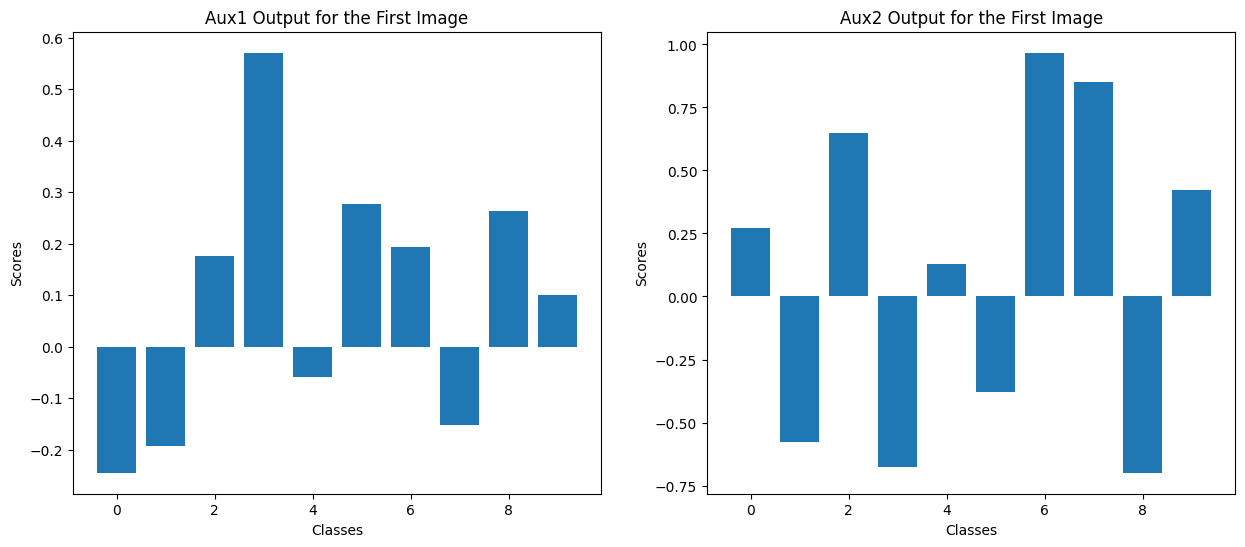

In [12]:
model_lenet5.eval()
with torch.no_grad():
    # Get one batch of data
    for images, _ in test_loader:
        images = images.to(device)
        _, aux1, aux2 = model_lenet5(images)

        # Select the first image in the batch for visualization
        scores_aux1 = aux1[0].cpu().numpy()
        scores_aux2 = aux2[0].cpu().numpy()

        # Plot
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        plt.title('Aux1 Output for the First Image')
        plt.bar(np.arange(10), scores_aux1)
        plt.xlabel('Classes')
        plt.ylabel('Scores')

        plt.subplot(1, 2, 2)
        plt.title('Aux2 Output for the First Image')
        plt.bar(np.arange(10), scores_aux2)
        plt.xlabel('Classes')
        plt.ylabel('Scores')

        plt.show()
        break  # Only visualize for the first batch


### Test in how many images the first Conv layer predicted the same as the second

In [14]:
sum = 0
iterations = 5

for i in range(iterations):
    total_samples = 0
    matching_highest_scores = 0

    model_lenet5.eval()
    with torch.no_grad():
        for X, y in train_loader:
            X = X.to(device)
            _, aux1, aux2 = model_lenet5(X)

            # Get the indices of the max score for each sample in the batch
            max_indices_aux1 = torch.argmax(aux1, dim=1)
            max_indices_aux2 = torch.argmax(aux2, dim=1)

            # Count how many times the highest scoring classes match
            matches = torch.sum(max_indices_aux1 == max_indices_aux2)
            matching_highest_scores += matches.item()

            total_samples += X.size(0)

    # Calculate the percentage
    percentage_matching = (matching_highest_scores / total_samples) * 100
    print(f'Percentage of matching highest scores: {percentage_matching:.2f}%')
    sum += percentage_matching

average_percentage = sum/iterations
print(f'The average percentage of matching highest scores of {iterations} iterations is: {average_percentage:.2f}%')

Percentage of matching highest scores: 13.87%
Percentage of matching highest scores: 14.01%
Percentage of matching highest scores: 14.16%
Percentage of matching highest scores: 14.24%
Percentage of matching highest scores: 13.91%
The average percentage of matching highest scores of 5 iterations is: 14.04%


### t-SNE visualization

c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


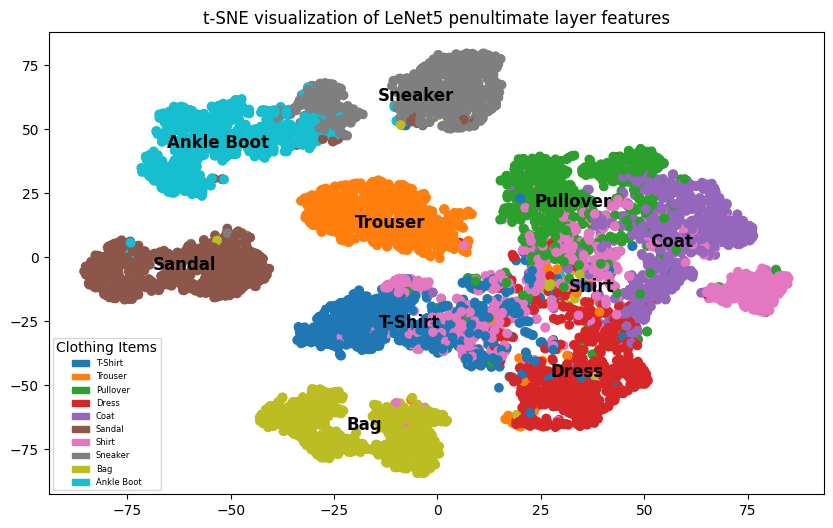

In [15]:
features = []
labels_list = []

model_lenet5.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        feature = model_lenet5.get_features(X)
        features.append(feature.cpu().numpy())
        labels_list.append(y.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels_list, axis=0)

features = features[::1]
labels = labels[::1]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=123).fit_transform(features)

# Create a color map with distinct colors for each label
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
custom_cmap = ListedColormap(custom_colors)

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap=custom_cmap)
plt.title('t-SNE visualization of LeNet5 penultimate layer features')

# Calculate centroids for each class
centroids = {}
for i in range(10):
    indices = labels == i
    centroids[i] = np.mean(tsne[indices], axis=0)
    
# Plot label names at centroids
for i, centroid in centroids.items():
    plt.text(centroid[0], centroid[1], labels_map[i],
             color='black', fontsize=12, fontweight='demi', ha='center', va='center')   
    

# Create a legend
handles = [mpatches.Patch(color=custom_cmap(i), label=labels_map[i]) for i in range(10)]
plt.legend(handles=handles, title='Clothing Items', fontsize='6', loc='lower left')

# Save plot to file
save_path = os.path.join(plots_path +'/', f'tSNE.png')
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

### Plot metrics and store model

In [16]:
def plot_train_val_metrics(history, model_name, plots_path='graphs'):
    '''
    Plots accuracy and loss for training and validation sets and outputs to file.

    :param history: dictionary of training and validation results
    :param model_name: model name for plot title and output file name
    :param plots_path: plots directory path
    '''
    
    plt.figure(figsize=(10, 4))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', color='black')
    plt.plot(history['val_loss'], label='Validation Loss', color='red')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy', color='black')
    plt.plot(history['val_acc'], label='Validation Accuracy', color='red')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Add a main title for the whole figure
    plt.suptitle(f'Training and Validation Metrics for {model_name}', fontsize=16, y=1.05)

    # Adjust layout and show plot
    plt.tight_layout()
    
    # Save plot to file
    save_path = os.path.join(plots_path +'/', f'{model_name}_metrics.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()

In [17]:
def export_model(model, model_name, models_path='models'):
    '''
    Outputs model to file.

    :param model: model
    :param model_name: model name for output file name
    :param models_path: models directory path
    '''

    # Export model to TorchScript
    model_scripted = torch.jit.script(model)
    
    # Save model
    save_path = os.path.join(models_path, model_name + '.pt')
    model_scripted.save(save_path)

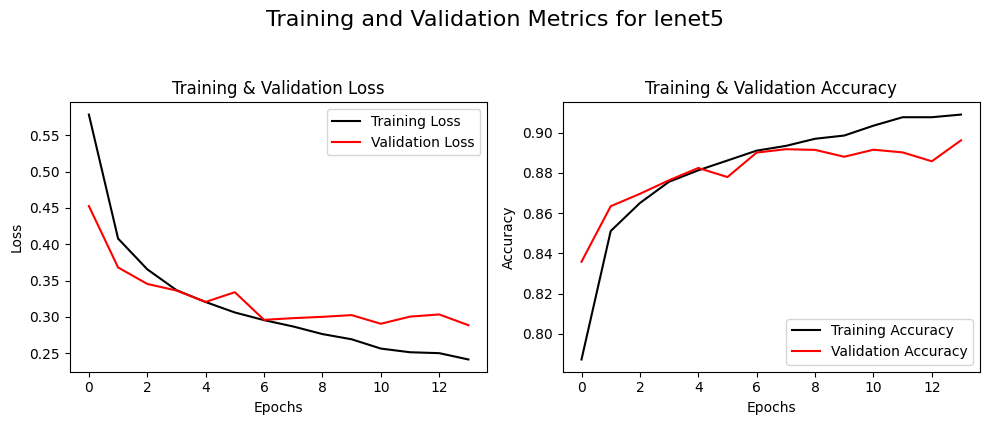

In [18]:
plot_train_val_metrics(history_lenet5, 'lenet5', plots_path)

In [19]:
export_model(model_lenet5, 'lenet5_model_original')

### Evaluation on the test set

In [21]:
def test_model(model, test_loader, num_classes):
    '''
    Tests a trained model on test data.

    :param model: model
    :param test_loader: test data loader
    :param num_classes: Number of classes
    :return: returns test loss, test accuracy, predicted labels, and actual labels
    '''
    
    # Define Loss Function
    loss_fn = nn.CrossEntropyLoss()
    # Define Optimizer
    # Define output accuracy function
    accuracy = Accuracy(task='multiclass', num_classes=num_classes)
    
    # model to the appropriate device
    model_lenet5 = model.to(device)
    
    test_loss, test_acc = 0, 0
    y_preds = []
    y_labels = []

    # Set model to evaluation mode
    model_lenet5.eval()
    with torch.inference_mode():
        # Iterating over batches of test data
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_pred, _, _ = model_lenet5(X)
    
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy(y_pred, y)
    
            # Store predictions and labels for confusion matrix
            y_preds.extend(y_pred.argmax(dim=1).cpu().numpy())
            y_labels.extend(y.cpu().numpy())

        # Average test loss and accuracy over all batches
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)
    
    print(f'Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}')

    return test_loss, test_acc, y_preds, y_labels

In [22]:
test_loss, test_acc, y_preds, y_labels = test_model(model_lenet5, test_loader, 10)

Test loss:  0.29473| Test acc:  0.89657


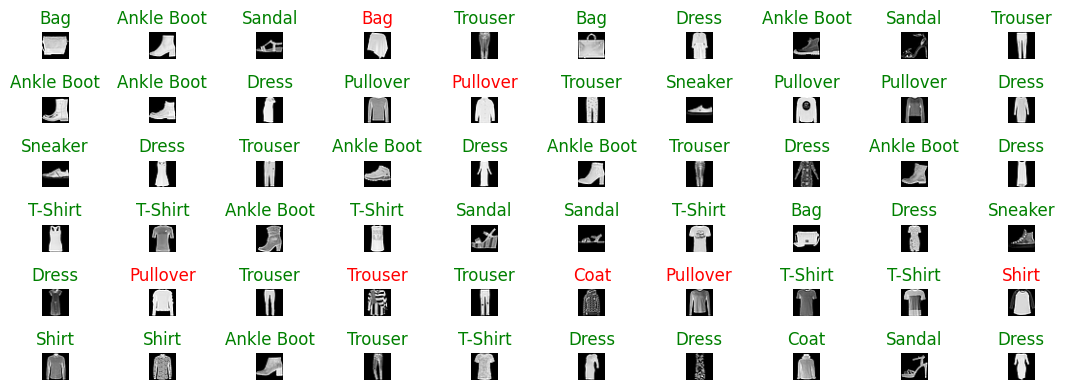

In [23]:
# See random images with their labels
torch.manual_seed(22)  # setting random seed
%matplotlib inline
fig = plt.figure(figsize=(12, 4))

rows, cols = 6, 10
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
    img, label_gt = test_dataset[random_idx]
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = int(torch.argmax(model_lenet5(img_temp)[0]))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    plt.imshow(img, cmap='gray')
    if label_pred == label_gt:
        plt.title(labels_map[label_pred], color='g') # green label for correct prediction
    else:
        plt.title(labels_map[label_pred], color='r') # red label for incorrect prediction
    plt.axis(False)
    
    # Save plot to file
    save_path = os.path.join(plots_path +'/', 'test_set_classific.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.tight_layout()

## Model variants

### 1st variant
Change learning rate to adaptive learning rate (1/2 every 5 epochs)

In [24]:
class LeNet5_v1(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28x28 -> 32x32 -> 28x28
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 14x14 -> 10x10
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10 -> 5x5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(6*14*14, 10)  # After first pooling
        self.aux_output2 = nn.Linear(16*5*5, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x

In [25]:
model_lenet5_v1 = LeNet5_v1()

summary(model=model_lenet5_v1, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v1 (LeNet5_v1)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 6, 14, 14]       --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─ReLU (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─MaxPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
├─Linear (aux_output1)                   [1, 1176]            [1, 10]              11,770               True
├─Sequential (second_wave)               [1, 6, 14, 14]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─ReLU (1)   

In [26]:
model_lenet5_v1, history_lenet5_v1, learning_rates_lenet5_v1 = train_model_multiclass(model_lenet5_v1, 10, train_loader, validation_loader, device,
                                                                                      EPOCHS, LEARNING_RATE, True, 5, 0.5,
                                                                                      tensorboard_tracking=TENSORBOARD)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.58561| Train acc:  0.78717| Val loss:  0.42844| Val acc:  0.84408
Epoch: 1| Train loss:  0.41072| Train acc:  0.84869| Val loss:  0.38685| Val acc:  0.85608
Epoch: 2| Train loss:  0.36534| Train acc:  0.86604| Val loss:  0.34360| Val acc:  0.87125
Epoch: 3| Train loss:  0.34255| Train acc:  0.87392| Val loss:  0.34035| Val acc:  0.87583
Epoch: 4| Train loss:  0.31759| Train acc:  0.88379| Val loss:  0.33821| Val acc:  0.87075
Epoch: 5| Train loss:  0.27993| Train acc:  0.89613| Val loss:  0.29455| Val acc:  0.88942
Epoch: 6| Train loss:  0.27052| Train acc:  0.90035| Val loss:  0.29001| Val acc:  0.89633
Epoch: 7| Train loss:  0.25896| Train acc:  0.90338| Val loss:  0.28935| Val acc:  0.89108
Epoch: 8| Train loss:  0.25685| Train acc:  0.90535| Val loss:  0.28187| Val acc:  0.89708
Epoch: 9| Train loss:  0.24625| Train acc:  0.90881| Val loss:  0.28107| Val acc:  0.89433
Epoch: 10| Train loss:  0.23100| Train acc:  0.91285| Val loss:  0.27562| Val acc:  0.9005

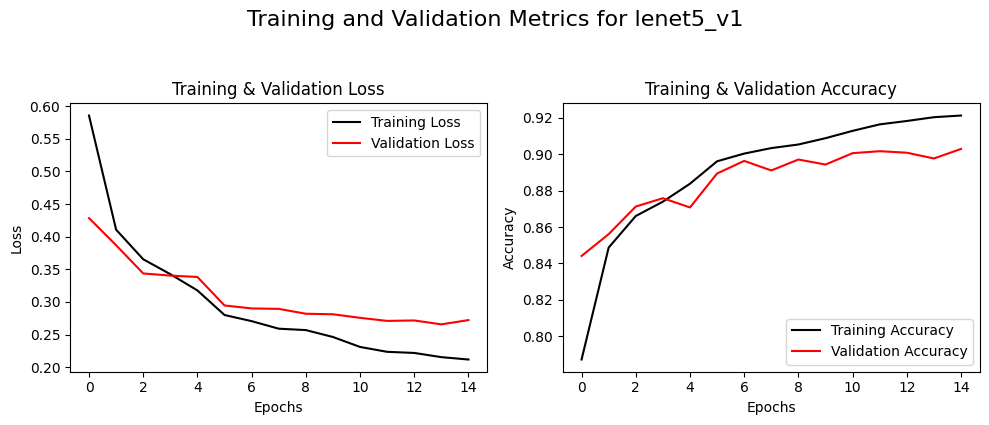

In [29]:
plot_train_val_metrics(history_lenet5_v1, 'lenet5_v1')

In [30]:
export_model(model_lenet5_v1, 'lenet5_model_v1')

In [31]:
def plot_lr(lr_per_epoch, file_name='adaptive_lr', plots_path='graphs'):
    '''
    Plots learning rates for every epoch and outputs to file.

    :param lr_per_epoch: learning rate for every epoch
    :param file_name: output file name (exclusing extension)
    :param plots_path: plots directory path
    '''
    # Plot learning rate
    plt.plot(lr_per_epoch)
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('Adaptive Learning Rate During Training')

    # Save plot to file
    save_path = os.path.join(plots_path +'/', file_name + '.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()

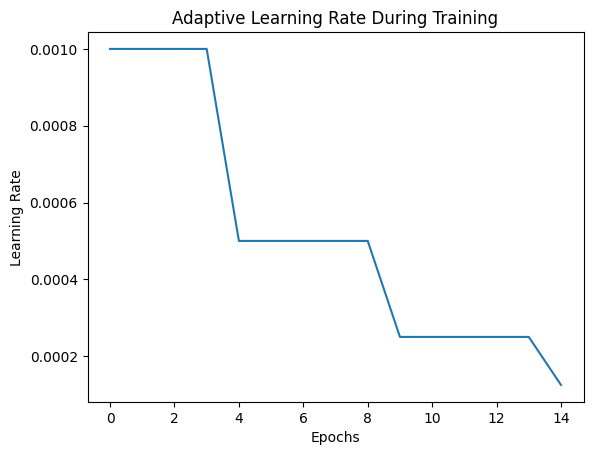

In [32]:
plot_lr(learning_rates_lenet5_v1, 'adaptive_lr')

### 2nd variant
Increase number of filters in convolution layers from 6 and 16 to 32 and 64

In [33]:
class LeNet5_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),   # 28x28 -> 32x32 -> 28x28
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1),  # 14x14 -> 10x10
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10 -> 5x5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(32*14*14, 10)  # After first pooling
        self.aux_output2 = nn.Linear(64*5*5, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x

In [34]:
model_lenet5_v2 = LeNet5_v2()

summary(model=model_lenet5_v2, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v2 (LeNet5_v2)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 32, 14, 14]      --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 32, 28, 28]      832                  True
│    └─ReLU (1)                          [1, 32, 28, 28]      [1, 32, 28, 28]      --                   --
│    └─MaxPool2d (2)                     [1, 32, 28, 28]      [1, 32, 14, 14]      --                   --
├─Linear (aux_output1)                   [1, 6272]            [1, 10]              62,730               True
├─Sequential (second_wave)               [1, 32, 14, 14]      [1, 64, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 32, 14, 14]      [1, 64, 10, 10]      51,264               True
│    └─ReLU (1)   

In [35]:
model_lenet5_v2, history_lenet5_v2, learning_rates_lenet5_v2 = train_model_multiclass(model_lenet5_v2, 10, train_loader, validation_loader, device,
                                                                                      EPOCHS, LEARNING_RATE, True, 5, 0.5,
                                                                                      tensorboard_tracking=TENSORBOARD)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.52202| Train acc:  0.81085| Val loss:  0.37309| Val acc:  0.86733
Epoch: 1| Train loss:  0.36184| Train acc:  0.86894| Val loss:  0.34932| Val acc:  0.86933
Epoch: 2| Train loss:  0.32066| Train acc:  0.88119| Val loss:  0.30648| Val acc:  0.88767
Epoch: 3| Train loss:  0.29003| Train acc:  0.89500| Val loss:  0.30251| Val acc:  0.88575
Epoch: 4| Train loss:  0.27121| Train acc:  0.90150| Val loss:  0.29014| Val acc:  0.89275
Epoch: 5| Train loss:  0.22686| Train acc:  0.91623| Val loss:  0.25357| Val acc:  0.90900
Epoch: 6| Train loss:  0.21378| Train acc:  0.91998| Val loss:  0.25826| Val acc:  0.90767
Epoch: 7| Train loss:  0.20174| Train acc:  0.92383| Val loss:  0.24658| Val acc:  0.91267
Epoch: 8| Train loss:  0.19629| Train acc:  0.92658| Val loss:  0.24279| Val acc:  0.91083
Epoch: 9| Train loss:  0.18557| Train acc:  0.92992| Val loss:  0.25049| Val acc:  0.91242
Epoch: 10| Train loss:  0.15924| Train acc:  0.94154| Val loss:  0.24896| Val acc:  0.9139

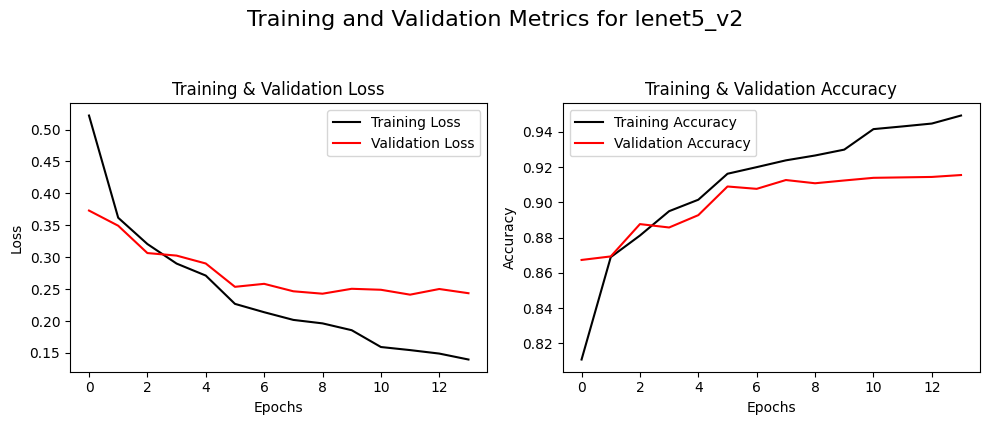

In [38]:
plot_train_val_metrics(history_lenet5_v2, 'lenet5_v2')

In [39]:
export_model(model_lenet5_v2, 'lenet5_model_v2')

### 3rd variant
Increase neurons in fully connected layers from 120 and 84 to 200 and 140 (maintain 0.7 ratio)

In [40]:
class LeNet5_v3(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),   # 28x28 -> 32x32 -> 28x28
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1),  # 14x14 -> 10x10
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10 -> 5x5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*5*5, out_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=140),
            nn.ReLU(),
            nn.Linear(in_features=140, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(32*14*14, 10)  # After first pooling
        self.aux_output2 = nn.Linear(64*5*5, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x

In [41]:
model_lenet5_v3 = LeNet5_v3()

summary(model=model_lenet5_v3, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v3 (LeNet5_v3)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 32, 14, 14]      --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 32, 28, 28]      832                  True
│    └─ReLU (1)                          [1, 32, 28, 28]      [1, 32, 28, 28]      --                   --
│    └─MaxPool2d (2)                     [1, 32, 28, 28]      [1, 32, 14, 14]      --                   --
├─Linear (aux_output1)                   [1, 6272]            [1, 10]              62,730               True
├─Sequential (second_wave)               [1, 32, 14, 14]      [1, 64, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 32, 14, 14]      [1, 64, 10, 10]      51,264               True
│    └─ReLU (1)   

In [42]:
model_lenet5_v3, history_lenet5_v3, learning_rates_lenet5_v3 = train_model_multiclass(model_lenet5_v3, 10, train_loader, validation_loader, device,
                                                                                      EPOCHS, LEARNING_RATE, True, 5, 0.5,
                                                                                      tensorboard_tracking=TENSORBOARD)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.52522| Train acc:  0.80898| Val loss:  0.38590| Val acc:  0.85625
Epoch: 1| Train loss:  0.36103| Train acc:  0.86781| Val loss:  0.32070| Val acc:  0.87833
Epoch: 2| Train loss:  0.31675| Train acc:  0.88392| Val loss:  0.30839| Val acc:  0.88725
Epoch: 3| Train loss:  0.28731| Train acc:  0.89217| Val loss:  0.29533| Val acc:  0.88958
Epoch: 4| Train loss:  0.26636| Train acc:  0.90046| Val loss:  0.28585| Val acc:  0.89542
Epoch: 5| Train loss:  0.22303| Train acc:  0.91652| Val loss:  0.24620| Val acc:  0.90983
Epoch: 6| Train loss:  0.20651| Train acc:  0.92204| Val loss:  0.24470| Val acc:  0.90942
Epoch: 7| Train loss:  0.19709| Train acc:  0.92575| Val loss:  0.24403| Val acc:  0.90908
Epoch: 8| Train loss:  0.18770| Train acc:  0.92977| Val loss:  0.24373| Val acc:  0.91300
Epoch: 9| Train loss:  0.17976| Train acc:  0.93292| Val loss:  0.25101| Val acc:  0.91058
Epoch: 10| Train loss:  0.15413| Train acc:  0.94300| Val loss:  0.24008| Val acc:  0.9155

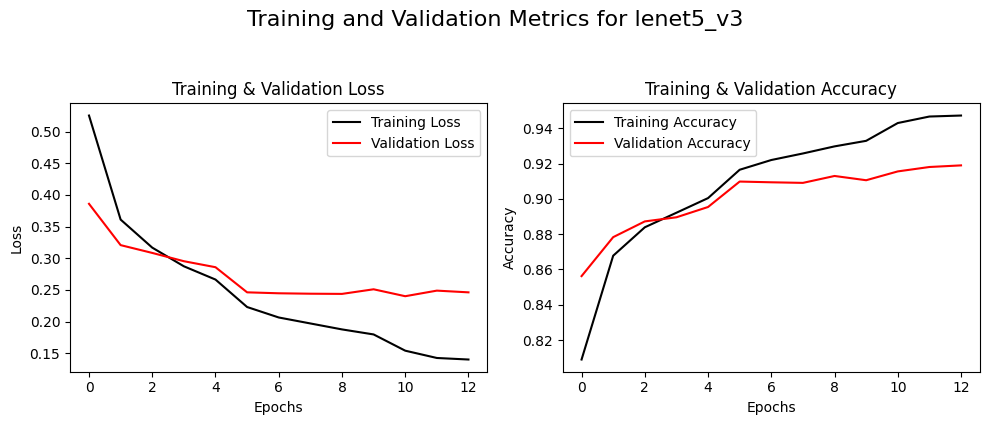

In [43]:
plot_train_val_metrics(history_lenet5_v3, 'lenet5_v3')

In [44]:
export_model(model_lenet5_v3, 'lenet5_model_v3')

### 4th variant
Add batch normalization

In [47]:
class LeNet5_v4(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),   # 28x28 -> 32x32 -> 28x28
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1),  # 14x14 -> 10x10
              nn.BatchNorm2d(64),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10 -> 5x5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*5*5, out_features=200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=140),
            nn.BatchNorm1d(140),
            nn.ReLU(),
            nn.Linear(in_features=140, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(32*14*14, 10)  # After first pooling
        self.aux_output2 = nn.Linear(64*5*5, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x

In [48]:
model_lenet5_v4 = LeNet5_v4()

summary(model=model_lenet5_v4, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v4 (LeNet5_v4)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 32, 14, 14]      --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 32, 28, 28]      832                  True
│    └─BatchNorm2d (1)                   [1, 32, 28, 28]      [1, 32, 28, 28]      64                   True
│    └─ReLU (2)                          [1, 32, 28, 28]      [1, 32, 28, 28]      --                   --
│    └─MaxPool2d (3)                     [1, 32, 28, 28]      [1, 32, 14, 14]      --                   --
├─Linear (aux_output1)                   [1, 6272]            [1, 10]              62,730               True
├─Sequential (second_wave)               [1, 32, 14, 14]      [1, 64, 5, 5]        --                   True
│    └─Conv2d (0) 

In [49]:
model_lenet5_v4, history_lenet5_v4, learning_rates_lenet5_v4 = train_model_multiclass(model_lenet5_v4, 10, train_loader, validation_loader, device,
                                                                                      EPOCHS, LEARNING_RATE, True, 5, 0.5,
                                                                                      tensorboard_tracking=TENSORBOARD)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.46868| Train acc:  0.83029| Val loss:  0.33178| Val acc:  0.87658
Epoch: 1| Train loss:  0.33204| Train acc:  0.87760| Val loss:  0.28859| Val acc:  0.89200
Epoch: 2| Train loss:  0.29168| Train acc:  0.89258| Val loss:  0.28992| Val acc:  0.89342
Epoch: 3| Train loss:  0.26742| Train acc:  0.90067| Val loss:  0.25773| Val acc:  0.90533
Epoch: 4| Train loss:  0.24870| Train acc:  0.90779| Val loss:  0.24810| Val acc:  0.90583
Epoch: 5| Train loss:  0.20702| Train acc:  0.92338| Val loss:  0.23566| Val acc:  0.91383
Epoch: 6| Train loss:  0.19008| Train acc:  0.92908| Val loss:  0.22079| Val acc:  0.91783
Epoch: 7| Train loss:  0.18026| Train acc:  0.93167| Val loss:  0.22887| Val acc:  0.91500
Epoch: 8| Train loss:  0.17279| Train acc:  0.93592| Val loss:  0.22267| Val acc:  0.91717
Epoch: 9| Train loss:  0.16457| Train acc:  0.93919| Val loss:  0.22242| Val acc:  0.91908
Epoch: 10| Train loss:  0.14085| Train acc:  0.94925| Val loss:  0.21620| Val acc:  0.9237

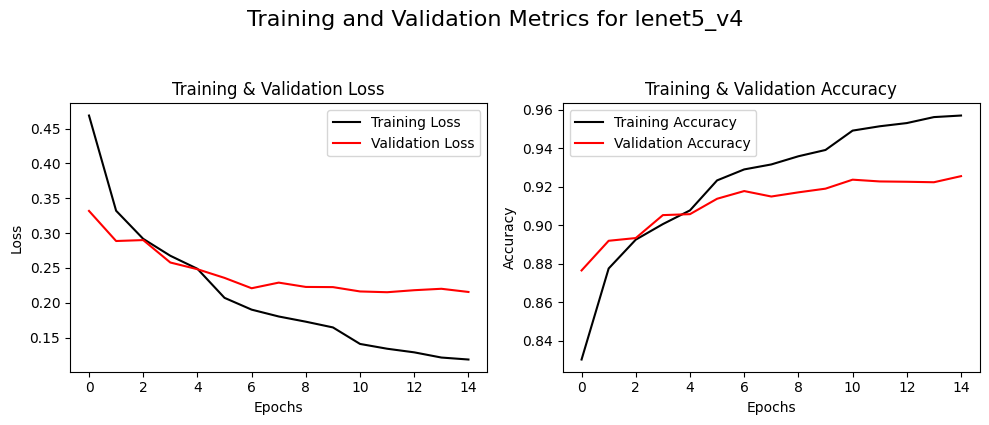

In [50]:
plot_train_val_metrics(history_lenet5_v4, 'lenet5_v4')

In [51]:
export_model(model_lenet5_v4, 'lenet5_model_v4')

## Store results in CSV

In [63]:
def export_model_metrics(model_metrics, file_name='model_metrics'):
    '''
    Outputs best epoch model training and validation results to file.

    :param model_metrics: dictionary of best epoch training and validation results dictionaries for every model
    :param file_name: output file name (exclusing extension)
    '''
    file_name = file_name + '.csv'
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        header = ['Model', 'Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy']
        writer.writerow(header)

        # Write the data for each model
        for model_name, metrics in model_metrics.items():
            row = [
                model_name,
                metrics['train_loss'],
                metrics['val_loss'],
                metrics['train_acc'].item() if torch.is_tensor(metrics['train_acc']) else metrics['train_acc'],
                metrics['val_acc'].item() if torch.is_tensor(metrics['val_acc']) else metrics['val_acc']
            ]
            writer.writerow(row)

In [54]:
history_lenet5['val_acc'][-1]

tensor(0.8962)

In [56]:
history_lenet5_v1['val_acc'][-1]

tensor(0.9029)

In [57]:
history_lenet5_v2['val_acc'][-1]

tensor(0.9155)

In [58]:
history_lenet5_v3['val_acc'][-1]

tensor(0.9190)

In [55]:
history_lenet5_v4['val_acc'][-1]

tensor(0.9256)

In [76]:
model_metrics = {
    'lenet5_model_original': {'train_loss': history_lenet5['train_loss'][-1], 
                              'val_loss': history_lenet5['val_loss'][-1], 
                              'train_acc': history_lenet5['train_acc'][-1], 
                              'val_acc': history_lenet5['val_acc'][-1]},
    'lenet5_model_v1': {'train_loss': history_lenet5_v1['train_loss'][-1], 
                        'val_loss': history_lenet5_v1['val_loss'][-1], 
                        'train_acc': history_lenet5_v1['train_acc'][-1], 
                        'val_acc': history_lenet5_v1['val_acc'][-1]},
    'lenet5_model_v2': {'train_loss': history_lenet5_v2['train_loss'][-1], 
                        'val_loss': history_lenet5_v2['val_loss'][-1], 
                        'train_acc': history_lenet5_v2['train_acc'][-1], 
                        'val_acc': history_lenet5_v2['val_acc'][-1]},
    'lenet5_model_v3': {'train_loss': history_lenet5_v3['train_loss'][-1], 
                        'val_loss': history_lenet5_v3['val_loss'][-1], 
                        'train_acc': history_lenet5_v3['train_acc'][-1], 
                        'val_acc': history_lenet5_v3['val_acc'][-1]},
    'lenet5_model_v4': {'train_loss': history_lenet5_v4['train_loss'][-1], 
                        'val_loss': history_lenet5_v4['val_loss'][-1], 
                        'train_acc': history_lenet5_v4['train_acc'][-1], 
                        'val_acc': history_lenet5_v4['val_acc'][-1]},
}

export_model_metrics(model_metrics, 'final_model_metrics')

In [77]:
model_metrics

{'lenet5_model_original': {'train_loss': 0.24146720034629107,
  'val_loss': 0.28865229891613126,
  'train_acc': tensor(0.9090),
  'val_acc': tensor(0.8962)},
 'lenet5_model_v1': {'train_loss': 0.21172514957934618,
  'val_loss': 0.27216319075226786,
  'train_acc': tensor(0.9213),
  'val_acc': tensor(0.9029)},
 'lenet5_model_v2': {'train_loss': 0.13963332044674703,
  'val_loss': 0.24355081402013698,
  'train_acc': tensor(0.9492),
  'val_acc': tensor(0.9155)},
 'lenet5_model_v3': {'train_loss': 0.1401702111819759,
  'val_loss': 0.24618290974448123,
  'train_acc': tensor(0.9473),
  'val_acc': tensor(0.9190)},
 'lenet5_model_v4': {'train_loss': 0.11849496780087551,
  'val_loss': 0.21545572095488508,
  'train_acc': tensor(0.9571),
  'val_acc': tensor(0.9256)}}

## Test the model with the highest validation accuracy

In [85]:
results = pd.read_csv('final_model_metrics.csv')

# Find the id of the model with the max Validation Accuracy
max_val_acc_id = results['Validation Accuracy'].idxmax()

# Retrieve the row of this specific model
max_model = results.loc[max_val_acc_id]

max_val_acc_formatted = float('{:.3f}'.format(max_model['Validation Accuracy'])) *100

print(f'The model with the highest validation accuracy ({np.round(max_val_acc_formatted, decimals=2)}%) is {max_model["Model"]}')

The model with the highest validation accuracy (92.6%) is lenet5_model_v4


In [86]:
results

,Model,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
0,lenet5_model_original,0.241467,0.288652,0.908958,0.896167
1,lenet5_model_v1,0.211725,0.272163,0.921271,0.902917
2,lenet5_model_v2,0.139633,0.243551,0.949250,0.915500
3,lenet5_model_v3,0.140170,0.246183,0.947250,0.919000
4,lenet5_model_v4,0.118495,0.215456,0.957083,0.925583


In [87]:
# Load best model
model_file = f'models/{max_model["Model"]}.pt'
model = torch.jit.load(model_file)

test_loss, test_acc, y_preds, y_labels = test_model(model, test_loader, 10)

Test loss:  0.23107| Test acc:  0.92542


In [88]:
def plot_confusion_matrix(preds, labels, labels_map, file_name='confusion_matrix', plots_path='graphs'):
    '''
    Plots confusion matrix of predicted labels and actual labels and outputs to file.

    :param preds: predicted labels
    :param labels: actual labels
    :param labels_map: dictionary indexing dataset's labels to image descriptors
    :param file_name: output file name (exclusing extension)
    :param plots_path: plots directory path
    '''
    
    # Extract label names in the order of their numerical values
    label_names = [labels_map[i] for i in range(len(labels_map))]

    # Compute the confusion matrix
    cm = confusion_matrix(labels, preds)

    # Plot the confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.title('Confusion Matrix')
    
    # Save plot to file
    save_path = os.path.join(plots_path +'/', file_name + '.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()

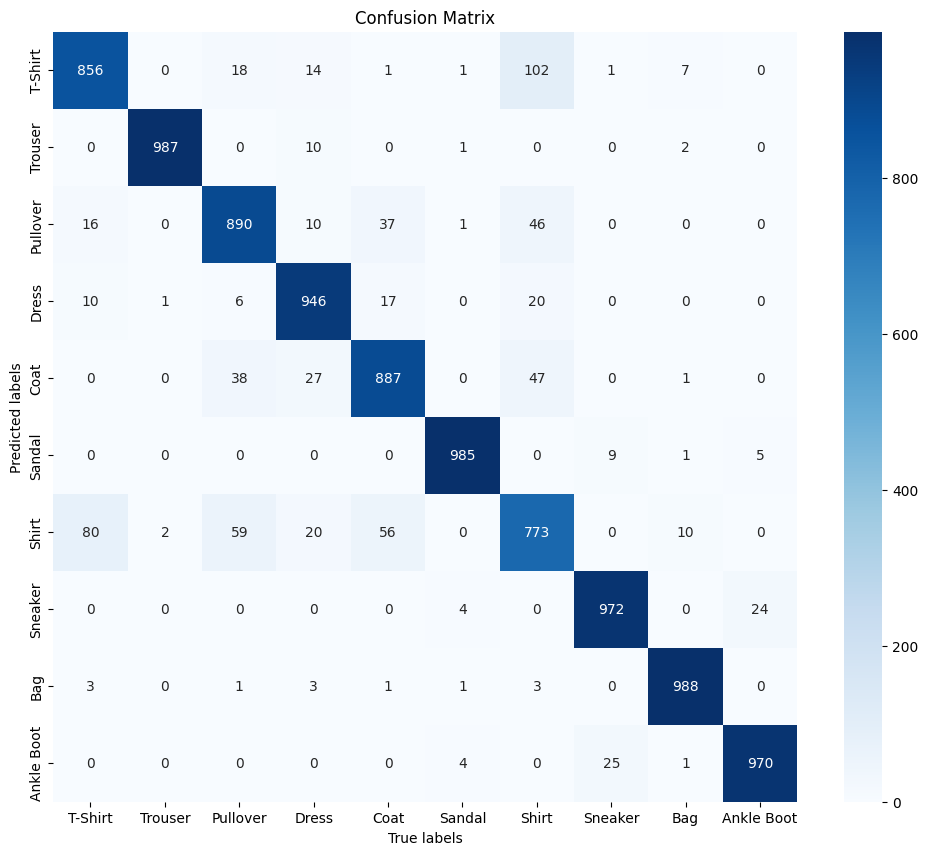

In [89]:
plot_confusion_matrix(y_preds, y_labels, labels_map, 'cm_best_model')

## Test the model with the highest validation accuracy after retraining on train and validation datasets

In [90]:
# Initialize appropriate model
if max_model['Model'] == 'lenet5_model_original':
    model = LeNet5()
    adapt_lr = False
elif max_model['Model'] == 'lenet5_model_v1':
    model = LeNet5_v1()
    adapt_lr = True
elif max_model['Model'] == 'lenet5_model_v2':
    model = LeNet5_v2()
    adapt_lr = True
elif max_model['Model'] == 'lenet5_model_v3':
    model = LeNet5_v3()
    adapt_lr = True
elif max_model['Model'] == 'lenet5_model_v4':
    model = LeNet5_v4()
    adapt_lr = True

# Retrain model on both train and validation data
model, history, learning_rates = train_model_multiclass(model, 10, train_validation_loader, None, device,
                                                        EPOCHS, LEARNING_RATE, adapt_lr, 5, 0.5,
                                                        tensorboard_tracking=False)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.44390| Train acc:  0.83932| Val loss:  0.00000| Val acc:  0.00000
Epoch: 1| Train loss:  0.31902| Train acc:  0.88217| Val loss:  0.00000| Val acc:  0.00000
Epoch: 2| Train loss:  0.27884| Train acc:  0.89650| Val loss:  0.00000| Val acc:  0.00000
Epoch: 3| Train loss:  0.25767| Train acc:  0.90398| Val loss:  0.00000| Val acc:  0.00000
Epoch: 4| Train loss:  0.23557| Train acc:  0.91352| Val loss:  0.00000| Val acc:  0.00000
Epoch: 5| Train loss:  0.19953| Train acc:  0.92592| Val loss:  0.00000| Val acc:  0.00000
Epoch: 6| Train loss:  0.18713| Train acc:  0.93057| Val loss:  0.00000| Val acc:  0.00000
Epoch: 7| Train loss:  0.17264| Train acc:  0.93587| Val loss:  0.00000| Val acc:  0.00000
Epoch: 8| Train loss:  0.16747| Train acc:  0.93818| Val loss:  0.00000| Val acc:  0.00000
Epoch: 9| Train loss:  0.15872| Train acc:  0.94077| Val loss:  0.00000| Val acc:  0.00000
Epoch: 10| Train loss:  0.13756| Train acc:  0.94990| Val loss:  0.00000| Val acc:  0.0000

In [93]:
test_loss, test_acc, y_preds, y_labels = test_model(model, test_loader, 10)

Test loss:  0.21361| Test acc:  0.92961


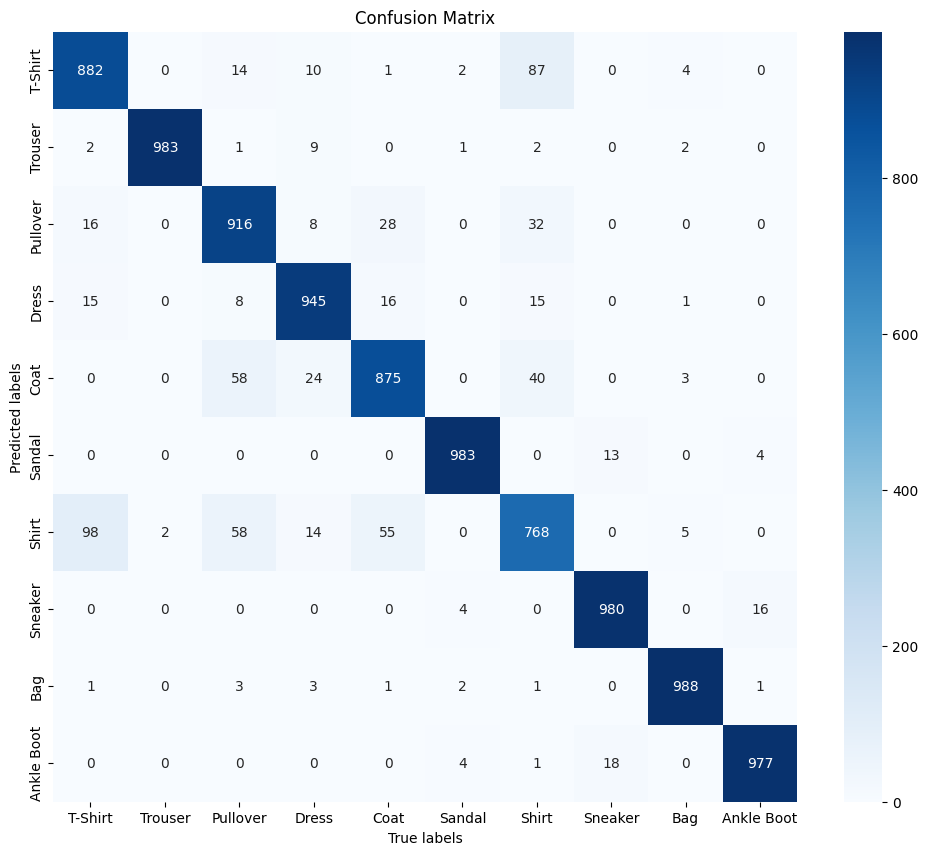

In [94]:
plot_confusion_matrix(y_preds, y_labels, labels_map, 'cm_best_model_retrained')

## K-fold cross validation

### Retrain the model with the highest validation accuracy with k-fold cross validation

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.46114| Train acc:  0.83356| Val loss:  0.34231| Val acc:  0.87650
Epoch: 1| Train loss:  0.32716| Train acc:  0.88033| Val loss:  0.30189| Val acc:  0.89058
Epoch: 2| Train loss:  0.29022| Train acc:  0.89312| Val loss:  0.29695| Val acc:  0.89133
Epoch: 3| Train loss:  0.26595| Train acc:  0.90173| Val loss:  0.28903| Val acc:  0.89417
Epoch: 4| Train loss:  0.24425| Train acc:  0.90823| Val loss:  0.25305| Val acc:  0.90950
Epoch: 5| Train loss:  0.20285| Train acc:  0.92585| Val loss:  0.23666| Val acc:  0.91475
Epoch: 6| Train loss:  0.18674| Train acc:  0.93069| Val loss:  0.23230| Val acc:  0.91542
Epoch: 7| Train loss:  0.17879| Train acc:  0.93367| Val loss:  0.23480| Val acc:  0.91392
Epoch: 8| Train loss:  0.17065| Train acc:  0.93667| Val loss:  0.24482| Val acc:  0.91267
Epoch: 9| Train loss:  0.16067| Train acc:  0.93981| Val loss:  0.24408| Val acc:  0.91383
Epoch: 10| Train loss:  0.13752| Train acc:  0.95031| Val loss:  0.23235| Val acc:  0.9196

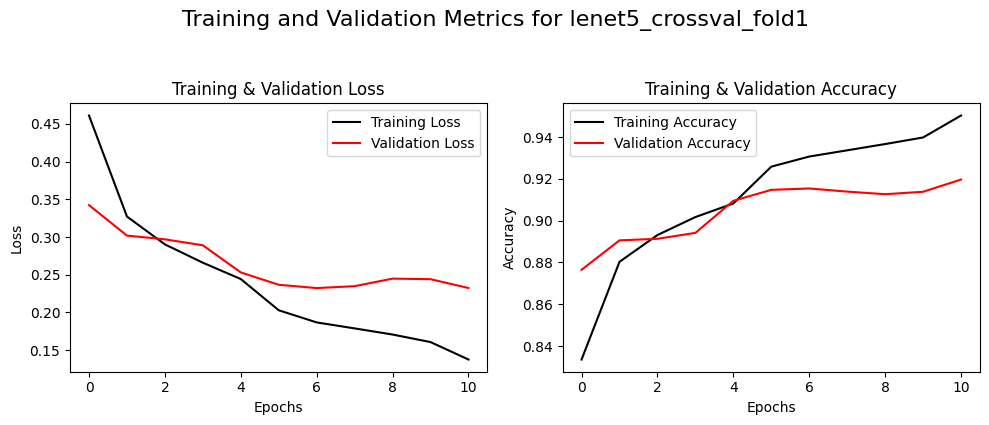

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.46900| Train acc:  0.83208| Val loss:  0.31601| Val acc:  0.88283
Epoch: 1| Train loss:  0.33054| Train acc:  0.87852| Val loss:  0.29123| Val acc:  0.89300
Epoch: 2| Train loss:  0.29041| Train acc:  0.89133| Val loss:  0.26973| Val acc:  0.90058
Epoch: 3| Train loss:  0.26691| Train acc:  0.90215| Val loss:  0.28538| Val acc:  0.89275
Epoch: 4| Train loss:  0.24949| Train acc:  0.90831| Val loss:  0.24993| Val acc:  0.90833
Epoch: 5| Train loss:  0.20508| Train acc:  0.92423| Val loss:  0.23817| Val acc:  0.91150
Epoch: 6| Train loss:  0.18897| Train acc:  0.92950| Val loss:  0.23215| Val acc:  0.91542
Epoch: 7| Train loss:  0.18102| Train acc:  0.93498| Val loss:  0.23322| Val acc:  0.91683
Epoch: 8| Train loss:  0.16997| Train acc:  0.93750| Val loss:  0.23849| Val acc:  0.91508
Epoch: 9| Train loss:  0.16308| Train acc:  0.94002| Val loss:  0.23395| Val acc:  0.91450
Epoch: 10| Train loss:  0.14217| Train acc:  0.94798| Val loss:  0.22876| Val acc:  0.9189

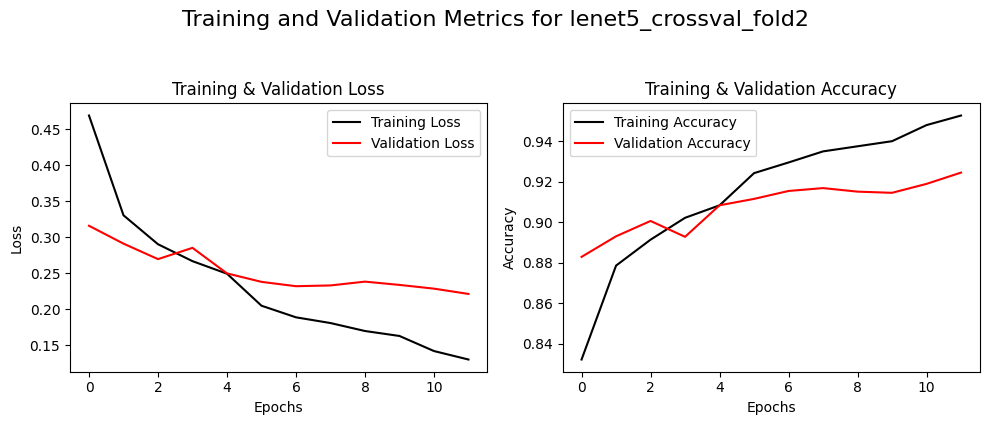

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.46927| Train acc:  0.83294| Val loss:  0.35019| Val acc:  0.86708
Epoch: 1| Train loss:  0.33308| Train acc:  0.87858| Val loss:  0.30473| Val acc:  0.88400
Epoch: 2| Train loss:  0.29149| Train acc:  0.89304| Val loss:  0.27136| Val acc:  0.90033
Epoch: 3| Train loss:  0.26634| Train acc:  0.90194| Val loss:  0.25756| Val acc:  0.90367
Epoch: 4| Train loss:  0.24840| Train acc:  0.90744| Val loss:  0.25289| Val acc:  0.90717
Epoch: 5| Train loss:  0.20771| Train acc:  0.92469| Val loss:  0.23430| Val acc:  0.91333
Epoch: 6| Train loss:  0.19147| Train acc:  0.93048| Val loss:  0.24529| Val acc:  0.90992
Epoch: 7| Train loss:  0.18339| Train acc:  0.93125| Val loss:  0.22282| Val acc:  0.91758
Epoch: 8| Train loss:  0.17160| Train acc:  0.93625| Val loss:  0.22966| Val acc:  0.91483
Epoch: 9| Train loss:  0.16684| Train acc:  0.93973| Val loss:  0.23154| Val acc:  0.91783
Epoch: 10| Train loss:  0.14169| Train acc:  0.94760| Val loss:  0.21818| Val acc:  0.9205

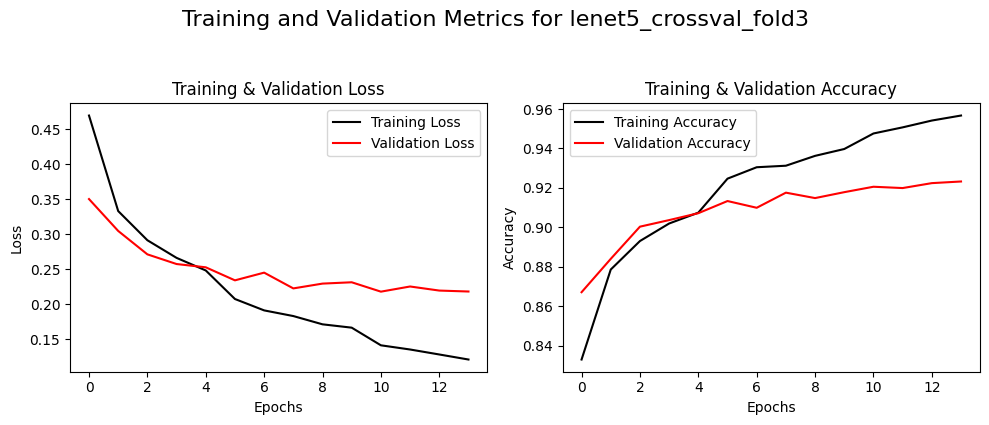

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.46607| Train acc:  0.83150| Val loss:  0.33890| Val acc:  0.87717
Epoch: 1| Train loss:  0.32620| Train acc:  0.87985| Val loss:  0.30894| Val acc:  0.88617
Epoch: 2| Train loss:  0.29064| Train acc:  0.89185| Val loss:  0.28888| Val acc:  0.89517
Epoch: 3| Train loss:  0.26443| Train acc:  0.90227| Val loss:  0.26700| Val acc:  0.90358
Epoch: 4| Train loss:  0.24178| Train acc:  0.91054| Val loss:  0.26468| Val acc:  0.90642
Epoch: 5| Train loss:  0.20085| Train acc:  0.92546| Val loss:  0.24152| Val acc:  0.91275
Epoch: 6| Train loss:  0.18697| Train acc:  0.93027| Val loss:  0.25243| Val acc:  0.90958
Epoch: 7| Train loss:  0.17796| Train acc:  0.93473| Val loss:  0.24687| Val acc:  0.91100
Epoch: 8| Train loss:  0.16738| Train acc:  0.93842| Val loss:  0.23926| Val acc:  0.91417
Epoch: 9| Train loss:  0.16132| Train acc:  0.94012| Val loss:  0.23775| Val acc:  0.91642
Epoch: 10| Train loss:  0.13450| Train acc:  0.95010| Val loss:  0.23675| Val acc:  0.9174

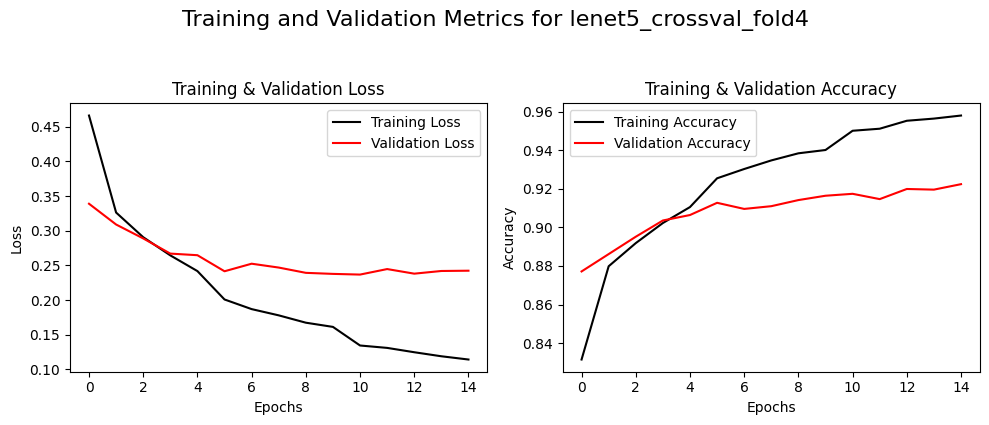

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.46430| Train acc:  0.83281| Val loss:  0.34515| Val acc:  0.87233
Epoch: 1| Train loss:  0.32754| Train acc:  0.87915| Val loss:  0.28498| Val acc:  0.89375
Epoch: 2| Train loss:  0.29338| Train acc:  0.89150| Val loss:  0.27312| Val acc:  0.89958
Epoch: 3| Train loss:  0.26702| Train acc:  0.90062| Val loss:  0.26020| Val acc:  0.90458
Epoch: 4| Train loss:  0.24665| Train acc:  0.90763| Val loss:  0.26229| Val acc:  0.90508
Epoch: 5| Train loss:  0.20600| Train acc:  0.92387| Val loss:  0.23019| Val acc:  0.91492
Epoch: 6| Train loss:  0.19376| Train acc:  0.92881| Val loss:  0.23232| Val acc:  0.91692
Epoch: 7| Train loss:  0.18325| Train acc:  0.93173| Val loss:  0.23138| Val acc:  0.91700
Epoch: 8| Train loss:  0.17102| Train acc:  0.93633| Val loss:  0.22205| Val acc:  0.91917
Epoch: 9| Train loss:  0.16271| Train acc:  0.93956| Val loss:  0.22600| Val acc:  0.92050
Epoch: 10| Train loss:  0.14337| Train acc:  0.94840| Val loss:  0.22257| Val acc:  0.9215

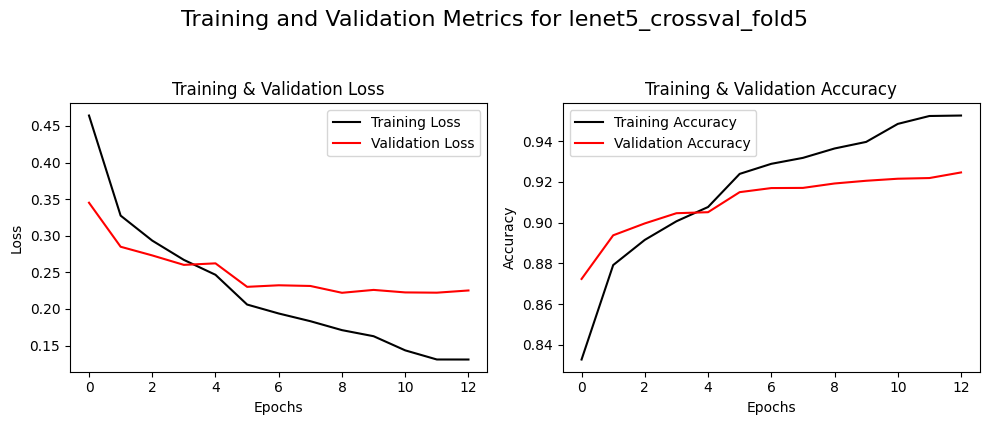

Average Training Loss: 0.1268951219284907
Average Training Accuracy: 0.9540459
Average Validation Loss: 0.22794227906018497
Average Validation Accuracy: 0.92288333


In [97]:
# Initialize results for for k-fold cross validation
kf_results = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# Initialize the k-fold cross validation
kf = KFold(n_splits=5, shuffle=True)

# Loop through each fold
for fold, (train_idx, test_idx) in enumerate(kf.split(train_val_dataset)):
    # Create data loaders for training and validation sets for fold
    train_loader_fold = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(train_idx))
    validation_loader_fold = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(test_idx))

    # Initialize appropriate model
    if max_model['Model'] == 'lenet5_model_original':
        model_fold = LeNet5()
        adapt_lr = False
    elif max_model['Model'] == 'lenet5_model_v1':
        model_fold = LeNet5_v1()
        adapt_lr = True
    elif max_model['Model'] == 'lenet5_model_v2':
        model_fold = LeNet5_v2()
        adapt_lr = True
    elif max_model['Model'] == 'lenet5_model_v3':
        model_fold = LeNet5_v3()
        adapt_lr = True
    elif max_model['Model'] == 'lenet5_model_v4':
        model_fold = LeNet5_v4()
        adapt_lr = True

    # Train model on fold
    model_fold, history_fold, learning_rates_fold = train_model_multiclass(model_fold, 10, train_loader_fold, validation_loader_fold, device,
                                                                           EPOCHS, LEARNING_RATE, adapt_lr, 5, 0.5,
                                                                           tensorboard_tracking=False)

    # Export model for fold
    export_model(model_fold, max_model['Model'] + '_crossval_fold' + str(fold + 1))
    
    # Plot results for fold
    plot_train_val_metrics(history_fold, 'lenet5_crossval_fold' + str(fold + 1))

    # Store performance metrics for fold
    kf_results['train_loss'].append(history_fold['train_loss'][-1])
    kf_results['train_acc'].append(history_fold['train_acc'][-1])
    kf_results['val_loss'].append(history_fold['val_loss'][-1])
    kf_results['val_acc'].append(history_fold['val_acc'][-1])

# Calculate averages across folds
avg_train_loss = np.mean(kf_results['train_loss'])
avg_train_acc = np.mean(kf_results['train_acc'])
avg_val_loss = np.mean(kf_results['val_loss'])
avg_val_acc = np.mean(kf_results['val_acc'])

print('Average Training Loss:', avg_train_loss)
print('Average Training Accuracy:', avg_train_acc)
print('Average Validation Loss:', avg_val_loss)
print('Average Validation Accuracy:', avg_val_acc)